In [ ]:
6->3->6

## Imports

In [1]:
import random

import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e1_classic
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Get Data

In [3]:
input_data = get_dataset(img_width=8, img_height=8, train=True)
print("Original data set size:", len(input_data))

# Select only the pictures with numbers 0 or 1. (jus to compare with literature)
filtered_data = [image for image in input_data if image[1] in [0, 1]]
input_data = filtered_data
print("Final data set szize:", len(input_data))

Original data set size: 60000
Final data set szize: 12665


## Training node

In [45]:
shots = 2500
nr_trash=3
nr_latent=3
nr_ent=0
spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [27]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state):
    #initilaization
    setAB_amplitude(spec, *init_params)

    setAux(spec, reinit_state)

    setEnt(spec, inputs=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)])

    #encoder

    for params in encoder_params:
        e1_classic(params, [*spec.latent_qubits, *spec.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [28]:
epochs = 2000
learning_rate = 0.0003
batch_size = 5
num_samples = 20

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [29]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [30]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [31]:
def fidelity(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [32]:
def iterate_batches(X, batch_size):
    X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in X]
    X2 = []
    for i in range(len(X1)):
        X2.append([X1[1], X[i][1]])
    X = X2
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [33]:
training_data = [input_data[i] for i in range(num_samples)]
test_data = [input_data[i] for i in range(num_samples,num_samples+num_samples)]

In [34]:
X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in training_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_training = X2

X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in test_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_tes = X2

In [35]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder = 2 * 3 * nr_encod_qubits + 3 * (nr_encod_qubits - 1) * nr_encod_qubits
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)


###  training

In [36]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))

Epoch:0 | Loss:1.822035446614595 | Fidelity:0.5488367429173977
Test-Epoch:0 | Loss:1.8070217392687298 | Fidelity:0.5533967734138512
Epoch:5 | Loss:1.8103595932809349 | Fidelity:0.5523764470392809
Test-Epoch:5 | Loss:1.7952472212563937 | Fidelity:0.5570263460985364
Epoch:10 | Loss:1.798475335046874 | Fidelity:0.5560265300907988
Test-Epoch:10 | Loss:1.7833010654401924 | Fidelity:0.5607578099849101
Epoch:15 | Loss:1.7863565179940502 | Fidelity:0.5597986683660038
Test-Epoch:15 | Loss:1.7711392427627284 | Fidelity:0.5646083469079148
Epoch:20 | Loss:1.7740125642981366 | Fidelity:0.5636938656044049
Test-Epoch:20 | Loss:1.7587486293088408 | Fidelity:0.5685860863430972
Epoch:25 | Loss:1.7614676744362179 | Fidelity:0.5677084027784184
Test-Epoch:25 | Loss:1.746175597714436 | Fidelity:0.5726800908848442
Epoch:30 | Loss:1.7487529152078245 | Fidelity:0.5718360731831336
Test-Epoch:30 | Loss:1.733464988837497 | Fidelity:0.5768792600020286
Epoch:35 | Loss:1.735897624069566 | Fidelity:0.576070838587613


Epoch:305 | Loss:1.1978931774882609 | Fidelity:0.8347989777325535
Test-Epoch:305 | Loss:1.1986495487129223 | Fidelity:0.8342722033089431
Epoch:310 | Loss:1.1932009788420856 | Fidelity:0.8380817797940685
Test-Epoch:310 | Loss:1.1942247115939035 | Fidelity:0.8373633456850204
Epoch:315 | Loss:1.1886416278378829 | Fidelity:0.8412964652928918
Test-Epoch:315 | Loss:1.189932717420007 | Fidelity:0.8403836497312083
Epoch:320 | Loss:1.1842125086295012 | Fidelity:0.8444430308858232
Test-Epoch:320 | Loss:1.185770875400569 | Fidelity:0.8433332448498424
Epoch:325 | Loss:1.1799112312161386 | Fidelity:0.8475213842733712
Test-Epoch:325 | Loss:1.1817367595387216 | Fidelity:0.8462121465954395
Epoch:330 | Loss:1.1757355487084677 | Fidelity:0.8505313980669277
Test-Epoch:330 | Loss:1.1778281335918332 | Fidelity:0.8490203039644338
Epoch:335 | Loss:1.1716832841502163 | Fidelity:0.8534729593972724
Test-Epoch:335 | Loss:1.1740428846469717 | Fidelity:0.8517576428229832
Epoch:340 | Loss:1.1677522687214958 | Fidel

Test-Epoch:605 | Loss:1.0873161660190207 | Fidelity:0.9196956977668137
Epoch:610 | Loss:1.0664934115726605 | Fidelity:0.9376522997225006
Test-Epoch:610 | Loss:1.0867554508813675 | Fidelity:0.9201702178617935
Epoch:615 | Loss:1.0656550928978172 | Fidelity:0.9383899224661116
Test-Epoch:615 | Loss:1.0862038626633654 | Fidelity:0.9206374920707849
Epoch:620 | Loss:1.06482937052688 | Fidelity:0.939117597315331
Test-Epoch:620 | Loss:1.085660655697748 | Fidelity:0.921098130204696
Epoch:625 | Loss:1.0640154300578277 | Fidelity:0.9398359946205398
Test-Epoch:625 | Loss:1.0851251342696986 | Fidelity:0.9215527024659803
Epoch:630 | Loss:1.0632124959092126 | Fidelity:0.9405457552912256
Test-Epoch:630 | Loss:1.0845966520834387 | Fidelity:0.9220017396135844
Epoch:635 | Loss:1.0624198319936913 | Fidelity:0.9412474898208958
Test-Epoch:635 | Loss:1.0840746117324476 | Fidelity:0.9224457331418459
Epoch:640 | Loss:1.0616367422995803 | Fidelity:0.9419417774048864
Test-Epoch:640 | Loss:1.083558464156353 | Fide

Epoch:910 | Loss:1.027327289084894 | Fidelity:0.973399626997901
Test-Epoch:910 | Loss:1.0618021030382097 | Fidelity:0.9417950832256118
Epoch:915 | Loss:1.0268649671722714 | Fidelity:0.9738378773927299
Test-Epoch:915 | Loss:1.0615306220908816 | Fidelity:0.9420359424302942
Epoch:920 | Loss:1.0264114608291155 | Fidelity:0.9742681547926395
Test-Epoch:920 | Loss:1.0612624337157102 | Fidelity:0.9422740014444709
Epoch:925 | Loss:1.025966820300782 | Fidelity:0.9746903897991854
Test-Epoch:925 | Loss:1.0609973238959172 | Fidelity:0.942509446044653
Epoch:930 | Loss:1.0255310775717383 | Fidelity:0.9751045305889792
Test-Epoch:930 | Loss:1.0607350853399533 | Fidelity:0.9427424564536878
Epoch:935 | Loss:1.0251042457482966 | Fidelity:0.9755105435838172
Test-Epoch:935 | Loss:1.0604755191304753 | Fidelity:0.9429732058500875
Epoch:940 | Loss:1.024686318636245 | Fidelity:0.9759084139338372
Test-Epoch:940 | Loss:1.0602184361555431 | Fidelity:0.9432018590679284
Epoch:945 | Loss:1.0242772705328005 | Fidelity

## Rezults

In [37]:
import matplotlib.pyplot as plt

fidelity: 0.9797617872039799


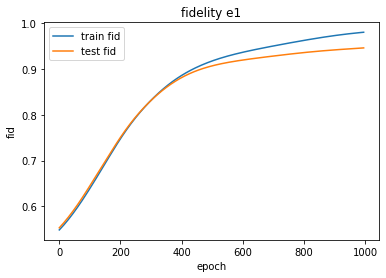

In [52]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")


plt.legend()
plt.title("fidelity e1",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.0206562585521686


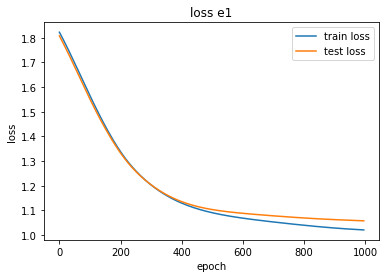

In [57]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("loss e1",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

In [47]:
name = "training_e1"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent ,"nr_ent":nr_ent  }
Training_param = { "num_samples": num_samples,
                    "batch_size": batch_size,
                    "nr_layers": 1,
                    "epochs": epochs,
                    "learning_rate":learning_rate ,
                    "beta1":beta1,
                    "beta2 ":beta2,
                     "optimizer":"Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

34182